In [1]:
import math
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
# initial parameters
up= 1.0
low= -1
dim= 2
mesh_size= 50
domain_size= 1000
bound_size= 250
t0= 0.0
t1= 1.0
#
v_layer= 6
v_hidden_size= 50
v_step= 1       
v_rate=0.015  
u_layer= 6
u_hidden_size= 20
u_step= 2
u_rate=0.015
out_size=1

# x value in domain and boundary
# x_domain (x & t)
x_domain=torch.Tensor(domain_size,dim).uniform_(low,up)
t_domain=torch.Tensor(domain_size,1).uniform_(t0,t1)
xt_domain= torch.cat((x_domain, t_domain), 1)

# x_boundary
xt_bound_list=[]
for i in range(dim):
  x_bound = torch.Tensor(bound_size,dim).uniform_(low,up)
  t_bound =torch.Tensor(bound_size,1).uniform_(t0,t1)
  x_bound[:,i] = up
  xt_bound_list.append(torch.cat((x_bound, t_bound), axis=1))
  x_bound = torch.Tensor(bound_size,dim).uniform_(low,up)
  t_bound =torch.Tensor(bound_size,1).uniform_(t0,t1)
  x_bound[:,i] = low
  xt_bound_list.append(torch.cat((x_bound, t_bound), 1))
xt_boundary = torch.cat(xt_bound_list, 0)

# x_initial
x_init = torch.Tensor(bound_size,dim+1).uniform_(low,up)
x_init[:, 2] = t0

# x value for network input
x_mesh=torch.linspace(low, up, mesh_size, requires_grad=True)
mesh1 ,mesh2 = torch.meshgrid(x_mesh,x_mesh)
mesh_1= torch.reshape(mesh1, [-1,1])
mesh_2= torch.reshape(mesh2, [-1,1])
xt_test= torch.cat((mesh_1,mesh_2),1)
xt_list=[]
for i in range(11):
  t_mesh=torch.ones(mesh_size**2,1)*(t0+0.1*i)
  xt=torch.cat((xt_test,t_mesh), 1)
  xt_list.append(xt)
xt_test=torch.cat((xt_list[0],xt_list[1],xt_list[2],xt_list[3],xt_list[4],xt_list[5],xt_list[6],xt_list[7],xt_list[8],xt_list[9],xt_list[10]),0)

# integration domain
int_x = (up-low)**dim 
int_t = (t1-t0)

# t on t0 and t1
lens=xt_domain.shape[0]
xt_right=xt_domain
for i in range(lens):
  xt_right[i,1]=t1
xt_left=xt_domain
for i in range(lens):
  xt_left[i,1]=t0

In [ ]:
# exact solution u(x) for pde
def func_u(x):
    lens=x.shape[0]
    u=torch.Tensor(lens,1)
    u[:,0] = 2 * torch.sin(x[:,0] * math.pi/2) * torch.cos(x[:,1]*math.pi/2) * torch.exp(-x[:,2])
    return(u) 

# f(x) = 1
def func_f(x):
    lens=x.shape[0]
    f=torch.Tensor(lens,1)
    f[:,0]=((math.pi**2)-2)*torch.sin(x[:,0]*math.pi/2)*torch.cos(x[:,1]*math.pi/2)*torch.exp(-x[:,2]) - 4*((torch.sin(x[:,0]*math.pi/2))**2)*torch.cos(x[:,1]*math.pi/2)*torch.exp(-2*x[:,2])
    return(f)

# g(x) = func_u(x_boundary)

def func_h(x):
  lens=x.shape[0]
  h=torch.Tensor(lens,1)
  h[:,0] = 2 * torch.sin(x[:,0] * math.pi/2) * torch.cos(x[:,1]*math.pi/2)
  return(h)


# w_val
def func_w(x):
  lens = x.shape[0]
  w_bool = torch.gt(1 - torch.abs(x[:, 0]), torch.zeros(lens)) & torch.gt(torch.abs(x[:, 0]), torch.zeros(lens))
  w_val = torch.where(w_bool, 1 - torch.abs(x[:, 0]) + torch.abs(x[:, 0]), torch.zeros(lens))
  w_val_=torch.reshape(w_val,(lens,1))
  return (w_val_)


# define generator and discriminator neural network
class generator(torch.nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.hidden00=torch.nn.Linear(dim+1, u_hidden_size)
        self.hidden0=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden1=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden2=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden3=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden4=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden5=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden6=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.predict=torch.nn.Linear(u_hidden_size, out_size)

    def forward(self, x):
        x=torch.tanh(self.hidden00(x))
        x=torch.tanh(self.hidden0(x))
        x=F.softplus(self.hidden1(x))
        x=torch.sin(self.hidden2(x))
        x=F.softplus(self.hidden3(x))
        x=torch.sin(self.hidden4(x))
        x=F.softplus(self.hidden5(x))
        x=torch.sin(self.hidden6(x))
        x=self.predict(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.hidden00_v=torch.nn.Linear(dim+1, v_hidden_size)
        self.hidden0_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden1_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden2_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden3_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden4_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden5_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden6_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.predict_v=torch.nn.Linear(v_hidden_size, out_size)

    def forward(self, x):
        x=torch.tanh(self.hidden00_v(x))
        x=torch.tanh(self.hidden0_v(x))
        x=F.softplus(self.hidden1_v(x))
        x=torch.sin(self.hidden2_v(x))
        x=F.softplus(self.hidden3_v(x))
        x=torch.sin(self.hidden4_v(x))
        x=F.softplus(self.hidden5_v(x))
        x=torch.sin(self.hidden6_v(x))
        x=self.predict_v(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

In [ ]:
# grad_u
def grad_u(y_output_u):
    optimizer_u_0.zero_grad()
    lens = xt_test.shape[0]
    y_output_u.backward(torch.ones([lens,1]), retain_graph=True)
    grad_u = xt_test_.grad
    return(grad_u)  

# grad_phi
def grad_phi(y_output_v):
   optimizer_v_0.zero_grad()
   lens = xt_test.shape[0]
   w = torch.reshape(func_w(xt_test_), (lens, 1))
   phi = y_output_v.mul(w)
   phi.backward(torch.ones([lens, 1]), retain_graph=True)
   grad_phi = xt_test_.grad
   return (grad_phi)


# loss function
def I(y_output_u, y_output_v):
    # gradients
    temp_grad_u=grad_u(y_output_u)
    temp_grad_v=grad_phi(y_output_v)
    lens=xt_test.shape[0]
    du_x=torch.Tensor(lens,1)
    dv_x=torch.Tensor(lens,1)
    dv_t=torch.Tensor(lens,1)
    for i in range(lens):
      du_x[i]=temp_grad_u[i,0]+temp_grad_u[i,1]
      dv_x[i]=temp_grad_v[i,0]+temp_grad_v[i,1]
      dv_t[i]=temp_grad_v[i,2]
    # integration components
    t1 = torch.sum(torch.mm(torch.transpose(net_u(xt_right),0,1), torch.mul(net_v(xt_right),func_w(xt_right))))
    t2 = torch.sum(torch.mm(torch.transpose(func_h(xt_left),0,1), torch.mul(net_v(xt_left),func_w(xt_left))))
    t3 = torch.sum(torch.mm(torch.transpose(y_output_u,0,1),dv_t))*int_t #####net_u(xt_test)
    t4 = 1*torch.sum(torch.mm(torch.transpose(du_x,0,1),dv_x))
    uu = torch.mul(torch.transpose(net_u(xt_domain),0,1), net_u(xt_domain)) #####net_u(xt_domain)
    t5 = torch.sum(torch.mm(uu, torch.mul(net_v(xt_right),func_w(xt_right))))
    t6 = torch.sum(torch.mm(torch.transpose(func_f(xt_domain),0,1), torch.mul(net_v(xt_right),func_w(xt_right))))
    I = t1-t2-t3+t4+t5-t6
    return(I)

def L_int(y_output_u, y_output_v):
    numerator = torch.log(torch.abs(I(y_output_u, y_output_v))**2)
    denominator = torch.log(torch.sum((y_output_v)**2))
    ratio=numerator-denominator
    return(ratio)

def L_init():
  result1 = torch.mean((func_u(x_init)-func_h(x_init))**2)
  return(result1)

def L_bd():
    result2 = torch.mean((net_u(xt_boundary_)-func_u(xt_boundary))**2)
    return(result2)

def Loss_u(y_output_u, y_output_v):
    return(L_int(y_output_u, y_output_v) + 25*L_bd() + 25*L_init())

def Loss_v(y_output_u,y_output_v):
    return(-L_int(y_output_u, y_output_v))

In [ ]:
# torch variables
xt_test_ = Variable(xt_test)
xt_test_.requires_grad_(True)

xt_domain_ = Variable(xt_domain)
xt_left_ = Variable(xt_left)
xt_right_ = Variable(xt_right)

xt_boundary_ = Variable(xt_boundary)

u_test = func_u(xt_test)
u_test_ = Variable(u_test)

# neural network models
net_u= generator()
net_v=discriminator()

# optimizers for grad_u and grad_phi
optimizer_u_0 = torch.optim.SGD(net_u.parameters(), lr = 0)
optimizer_v_0 = torch.optim.SGD(net_v.parameters(), lr = 0)

#optimizers for WAN
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = u_rate) 
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = v_rate)

# learning rate decays when loss doesn't change in 10 iterations
#scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, mode='min', factor=0.6, patience=200, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
#scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, mode='min', factor=0.6, patience=200, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#scheduler_u=torch.optim.lr_scheduler.StepLR(optimizer_u, step_size=600, gamma=0.6, last_epoch=-1) 
#scheduler_v=torch.optim.lr_scheduler.StepLR(optimizer_v, step_size=600, gamma=0.6, last_epoch=-1)

In [ ]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(xt_test_)
prediction_v = net_v(xt_test_)

for t in range(iteration):
    
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(xt_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u,prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(xt_test_)
            

    if t%10==0:
      print(t, loss_u, loss_v)
      print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
      print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(13.7822, grad_fn=<AddBackward0>) tensor(-14.4280, grad_fn=<NegBackward>)
第0个epoch的学习率：0.015000
第0个epoch的学习率：0.015000
10 tensor(38.4643, grad_fn=<AddBackward0>) tensor(-31.8267, grad_fn=<NegBackward>)
第10个epoch的学习率：0.015000
第10个epoch的学习率：0.015000
20 tensor(36.9275, grad_fn=<AddBackward0>) tensor(-38.3610, grad_fn=<NegBackward>)
第20个epoch的学习率：0.015000
第20个epoch的学习率：0.015000
30 tensor(41.0856, grad_fn=<AddBackward0>) tensor(-49.5271, grad_fn=<NegBackward>)
第30个epoch的学习率：0.015000
第30个epoch的学习率：0.015000
40 tensor(37.8026, grad_fn=<AddBackward0>) tensor(-38.0412, grad_fn=<NegBackward>)
第40个epoch的学习率：0.015000
第40个epoch的学习率：0.015000
50 tensor(36.9974, grad_fn=<AddBackward0>) tensor(-36.5832, grad_fn=<NegBackward>)
第50个epoch的学习率：0.015000
第50个epoch的学习率：0.015000
60 tensor(38.8910, grad_fn=<AddBackward0>) tensor(-36.6708, grad_fn=<NegBackward>)
第60个epoch的学习率：0.015000
第60个epoch的学习率：0.015000
70 tensor(51.0813, grad_fn=<AddBackward0>) tensor(-49.1066, grad_fn=<NegBackward>)
第70个epoch的学习率：0.0

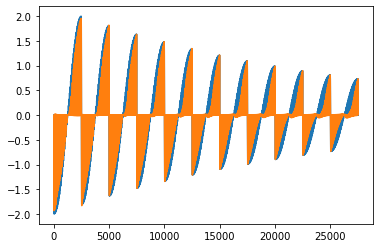

In [ ]:
plt.plot(u_test_.data.numpy())
plt.plot(prediction_u.data.numpy())

In [ ]:
# error and relative error
lens=xt_test.shape[0]
error_test = torch.Tensor(lens,1)
for i in range(lens):
  error_test[i] = torch.sqrt((torch.square(u_test_.data[i]-prediction_u.data[i]))) 

In [ ]:
# save data
import os
import scipy.io

# connect google dirve
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab_Notebooks')
file_path= './problem_data/'   #文件路径为当前运行目录下的/problem_data/
# 
data_save = {}
data_save['mesh1'] = mesh1.data.numpy()
data_save['mesh2'] = mesh2.data.numpy()
data_save['test_x'] = xt_test_.data.numpy()  
data_save['test_u'] = u_test_.data.numpy()  
data_save['pred_u'] = prediction_u.data.numpy()    
data_save['error_l2'] = error_test.numpy() 
# save data as .mat form
scipy.io.savemat(file_path+'time_involving_algorithm3', data_save)
print('Data saved in '+file_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Data saved in ./problem_data/
